# Paquetes a usar

In [39]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# lectura de datos

In [58]:
datos = pd.read_csv("ventas-por-factura.csv")
datos.shape

(25953, 6)

In [59]:
datos.head(10)

,N° de factura,Fecha de factura,ID Cliente,País,Cantidad,Monto
0,548370,3/30/2021 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.0,United Kingdom,163,"209,73"
2,C570727,10/12/2021 11:32:00,12471.0,Germany,-1,"-1,45"
3,549106,4/6/2021 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.0,United Kingdom,357,"344,83"
5,576630,11/16/2021 8:38:00,13816.0,Germany,91,"199,98"
6,538125,12/9/2020 15:46:00,18225.0,United Kingdom,16,"30,00"
7,544354,2/18/2021 10:42:00,13489.0,United Kingdom,64,"77,28"
8,546369,3/11/2021 11:41:00,15513.0,United Kingdom,10,"67,50"
9,570651,10/11/2021 13:34:00,14911.0,EIRE,86,"321,35"


## tipo de datos


In [60]:
datos.dtypes

N° de factura        object
Fecha de factura     object
ID Cliente          float64
País                 object
Cantidad              int64
Monto                object
dtype: object

## cambio del tipo de datos

In [61]:
datos['Fecha de factura'] = pd.to_datetime(datos['Fecha de factura'])
datos['ID Cliente'] = pd.to_numeric(datos['ID Cliente'].astype('Int64'))
datos['Monto'] = datos['Monto'].str.replace(',', '.')
datos['Monto'] = pd.to_numeric(datos['Monto'].astype('Float64'))
datos=datos[datos['N° de factura'].str.isnumeric()]
datos['N° de factura'] = pd.to_numeric(datos['N° de factura'].astype('int64'))
datos.shape

(22109, 6)

# limpieza de datos


## datos duplicados

In [62]:
datos = datos.drop_duplicates()
datos.shape

(22103, 6)

notamos que no tenemos valores duplicados

## datos faltantes

In [79]:
print(datos.isna().sum())

N° de factura       0
Fecha de factura    0
ID Cliente          0
País                0
Cantidad            0
Monto               0
AñoMes              0
Cohorte             0
MesDesdeInicio      0
dtype: int64


In [64]:
datos = datos.dropna()
datos.shape


(18566, 6)

In [65]:
datos = datos[(datos['Cantidad'] > 0) & (datos['Monto'] > 0)]
datos.shape

(18562, 6)

filtramos los valores sin sentido ya que tanto cantidad como monto no pueden ser negativos ni ceros 

In [66]:
datos.head()

,N° de factura,Fecha de factura,ID Cliente,País,Cantidad,Monto
0,548370,2021-03-30 16:14:00,15528,United Kingdom,123,229.33
1,575767,2021-11-11 11:11:00,17348,United Kingdom,163,209.73
3,549106,2021-04-06 12:08:00,17045,United Kingdom,1,39.95
4,573112,2021-10-27 15:33:00,16416,United Kingdom,357,344.83
5,576630,2021-11-16 08:38:00,13816,Germany,91,199.98


In [67]:
print(datos.describe())
datos.shape

       N° de factura               Fecha de factura    ID Cliente  \
count   18562.000000                          18562       18562.0   
mean   559513.666038  2021-07-01 13:53:06.393707520  15266.266782   
min    536365.000000            2020-12-01 08:26:00       12346.0   
25%    548334.250000            2021-03-30 13:56:15       13777.0   
50%    559805.000000            2021-07-12 14:21:30       15176.5   
75%    570828.500000            2021-10-12 13:16:15       16779.0   
max    581587.000000            2021-12-09 12:50:00       18287.0   
std     13041.106197                            NaN    1733.95285   

           Cantidad        Monto  
count  18562.000000      18562.0  
mean     278.448605   480.088778  
min        1.000000         0.38  
25%       74.000000        157.7  
50%      155.000000      302.875  
75%      290.000000     471.2575  
max    80995.000000     168469.6  
std      971.837519  1676.772723  


(18562, 6)

# Analisis de retencion por cohortes

In [68]:
datos['AñoMes'] = datos['Fecha de factura'].dt.to_period('M')

cohorte_inicio = datos.groupby('ID Cliente')['Fecha de factura'].min().dt.to_period('M')
datos['Cohorte'] = datos['ID Cliente'].map(cohorte_inicio)

## Indice de cohorte

In [69]:
def calcular_indice_cohorte(row):
    año_mes = row['AñoMes'].year * 12 + row['AñoMes'].month
    cohorte = row['Cohorte'].year * 12 + row['Cohorte'].month
    return año_mes - cohorte + 1 

datos['MesDesdeInicio'] = datos.apply(calcular_indice_cohorte, axis=1)

In [70]:
cohort_counts = datos.pivot_table(
    index='Cohorte',
    columns='MesDesdeInicio',
    values='ID Cliente',  
    aggfunc='nunique'
)

In [71]:
cohort_sizes = cohort_counts.iloc[:, 0]  # columna del mes 1
retention = cohort_counts.divide(cohort_sizes, axis=0)

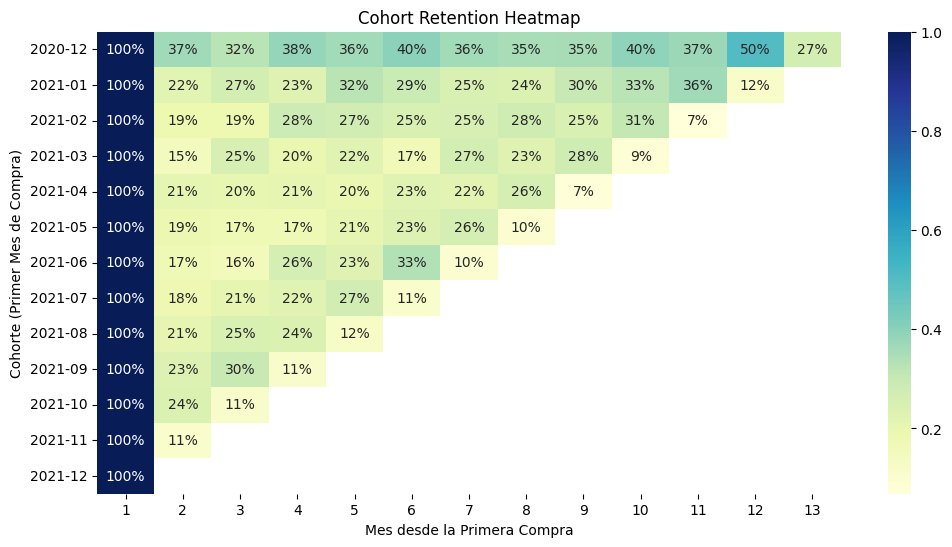

In [72]:
# Vuelve a intentar el gráfico
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Cohort Retention Heatmap")
plt.ylabel("Cohorte (Primer Mes de Compra)")
plt.xlabel("Mes desde la Primera Compra")
plt.show()

# Analisis RFM

In [73]:
fecha_referencia = datos['Fecha de factura'].max()
# Agrupar por cliente
rfm = datos.groupby('ID Cliente').agg({
    'Fecha de factura': lambda x: (fecha_referencia - x.max()).days,   # Recencia
    'N° de factura': 'nunique',                              # Frecuencia
    'Monto': 'sum'                                           # Monto
}).reset_index()

# Renombrar columnas
rfm.columns = ['ID Cliente', 'Recencia', 'Frecuencia', 'Monto']

In [74]:
# Crear cuartiles
rfm['R_Score'] = pd.qcut(rfm['Recencia'], 4, labels=[4, 3, 2, 1])  # Menor recencia = mejor score
rfm['F_Score'] = pd.qcut(rfm['Frecuencia'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monto'], 4, labels=[1, 2, 3, 4])

# Unir los scores
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [75]:
def clasificar_cliente(rfm_score):
    if rfm_score == '444':
        return 'Cliente Ideal'
    elif rfm_score.startswith('4'):
        return 'Cliente Leal'
    elif rfm_score.endswith('4'):
        return 'Gran Gastador'
    elif rfm_score.startswith('1'):
        return 'Cliente Perdido'
    elif rfm_score[1] == '1':
        return 'Cliente Ocasional'
    else:
        return 'Cliente Promedio'

rfm['Segmento'] = rfm['RFM_Score'].apply(clasificar_cliente)


C:\Users\Diego\AppData\Local\Temp\ipykernel_26684\2056181911.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




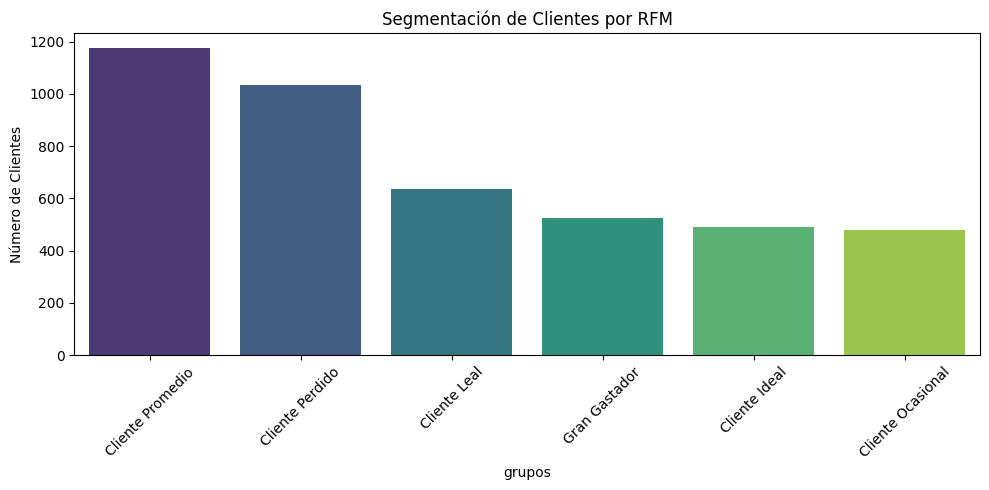

In [76]:
plt.figure(figsize=(10, 5))
sns.countplot(data=rfm, x='Segmento', order=rfm['Segmento'].value_counts().index, palette='viridis')
plt.title("Segmentación de Clientes por RFM")
plt.xticks(rotation=45)
plt.ylabel("Número de Clientes")
plt.xlabel("grupos")
plt.tight_layout()
plt.show()

# Exportamos los archivos para usarlo en power bi


In [77]:
datos.to_csv("datos_limpios.csv", index=False)

In [78]:
rfm.to_csv("rfm.csv", index=False)